To justify the use of q-grams over traditional word-level tokenization, a two-stage experiment was conducted. In the first stage, a classifier was trained using Bag-of-Words (BoW) features derived from standard word-level tokens. In the second stage, the same experimental setup was applied using q-gram tokenization instead.

The results are visualized in a scatter plot, where each point represents the F1-score of a model evaluated on a specific dataset. The x-axis shows performance using word-level tokenization (baseline), while the y-axis shows performance using q-grams. The diagonal line represents equal performance between both methods.

Points above the diagonal indicate performance improvement with q-grams, while points below indicate a drop in performance. The overall distribution of points reveals a clear trend favoring q-grams, supporting their effectiveness in handling informal language variations and sparsity in short-text NLP tasks such as tweet classification.

In [1]:
try:
    import microtc
except ImportError:
    !pip install microtc

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 1.8 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
from microtc import TextModel
import numpy as np
import pandas as pd
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score, recall_score, precision_score
from glob import glob
import warnings
warnings.filterwarnings('ignore')
from microtc.utils import tweet_iterator
from scipy.stats import ttest_rel
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score, precision_score, recall_score
import numpy as np

In [4]:
def performance(y, hy):
    funcs =  [f1_score, recall_score, precision_score]
    B = []
    for _ in range(500):
        s = np.random.randint(y.shape[0], size=y.shape[0])
        # s tiene los índices con reemplazo (repetidos) para usarlos en el arreglos de y_test y hy como re-muestreo para Boostraping
        _ = [func(y[s], hy[s]) for func in funcs] # f1_score(y_true, y_pred). aplicar las 3 métricas a y_test y hy re-ordenados por s
        B.append(_)
    B = np.array(B)
    medida = [func(y, hy) for func in funcs]
    error_estandar = B.std(axis=0) # desviación de las 3 métricas en los 500 renglones
    return medida, error_estandar.tolist()

In [5]:
if False:
    text_model_words = TextModel(token_list=[ -1], del_diac=False, num_option='delete', del_punc=False, url_option='delete', del_dup=True, lc=True, hashtag_option=None, q_grams_words=True)
    print(text_model_words.tokenize('¿Hola Mundo Cruel villáno?'))

    token_list = [-1, 2, 3, 4, (2, 1)]
    #token_list = [-1, 2, 3, 4]
    text_model_grams = TextModel(token_list=token_list, del_diac=True, num_option='delete', del_punc=True, url_option='delete', del_dup=False, lc=True, hashtag_option=None, q_grams_words=False)
    print(text_model_grams.tokenize('Hola Mundo cruel villáno?'))

    #linearSVC = LinearSVC(penalty='l1', C=1.0, dual=False, max_iter=10000, random_state = 42)


In [6]:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords

stopwords.words('spanish')[:10]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se']

In [7]:
stop_words_sp = set(stopwords.words('spanish'))

In [8]:
#import threading
import multiprocessing

resultados = []
lock = multiprocessing.Lock()

def run_thread(fn):

    n = fn.replace('/content/drive/MyDrive/datasets/', '').replace('_Es_train.json', '')


    try:

        text_model_words = TextModel(token_list=[ -1], del_diac=False, num_option='delete', del_punc=False, url_option='delete', del_dup=True, lc=True, hashtag_option=None, q_grams_words=True)

        token_list = [-1, 2, 3, 4, (2, 1)]
        #token_list = [-1, 2, 3, 4]
        text_model_grams = TextModel(token_list=token_list, del_diac=True, num_option='delete', del_punc=True, url_option='delete', del_dup=False, lc=True, hashtag_option=None, q_grams_words=False)


        tweets = list(tweet_iterator(fn))
        X_train = pd.DataFrame(tweets, columns=['text', 'klass'])
        #X_train = X_train.sample(200, replace=False)
        X_train['text'] = X_train['text'].apply(lambda x: ' '.join([word for word in str(x).split() if word.lower() not in stop_words_sp]))
        #X_train = X_train.reset_index(drop=True) # para garamtizar tener un index continuo y coincidir con las csr_matrix (e.g. KBest)


        fn = fn.replace('_train.','_test.')
        tweets_test = list(tweet_iterator(fn))
        X_test = pd.DataFrame(tweets_test, columns=['text', 'klass'])
        #X_test = X_test.sample(50, replace=False)
        X_test['text'] = X_test['text'].apply(lambda x: ' '.join([word for word in str(x).split() if word.lower() not in stop_words_sp]))
        #X_test = X_test.reset_index(drop=True) # para garamtizar tener un index continuo y coincidir con las csr_matrix (e.g. KBest)


        X = pd.concat([X_train, X_test])
        X['text'] = X['text'].apply(lambda x: ' '.join([word for word in str(x).split() if word.lower() not in stop_words_sp]))
        X_train, X_test = train_test_split(X, test_size=0.25, shuffle = True)

        print(X_train.shape, X_test.shape)

        # Words
        text_model = text_model_words.fit(X_train['text'])
        train_tokenized, test_tokenized = text_model.transform(X_train['text']), text_model.transform(X_test['text'])


        linearSVC = LinearSVC(penalty='l2', C=1.0, dual=False, max_iter=10000, random_state = 42)
        linearSVC.fit(train_tokenized, X_train.klass)
        y_pred = linearSVC.predict(test_tokenized)

        f1 = f1_score(X_test.klass, y_pred, average='macro')
        precision = precision_score(X_test.klass, y_pred, average='macro')
        recall = recall_score(X_test.klass, y_pred, average='macro')

        f1_, precision_, recall_ = 0.00, 0.00, 0.00

        # q-Grams
        mejor_f1, mejor_precision, mejor_recall = -1, -1, -1
        kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        for fold, (train_idx, test_idx) in enumerate(kf.split(X_train['text'], X_train['klass'])):
            X_tr, X_te = X_train.iloc[train_idx], X_train.iloc[test_idx]

            # Fit y transformación
            text_model = text_model_grams.fit(X_tr['text'])
            X_tr_token = text_model.transform(X_tr['text'])
            X_te_token = text_model.transform(X_te['text'])

            # Clasificador
            clf = LinearSVC(penalty='l1', C=1.0, dual=False, max_iter=10000, random_state=42)
            clf.fit(X_tr_token, X_tr['klass'])
            y_pred = clf.predict(X_te_token)

            # Métricas
            f1_ = f1_score(X_te['klass'], y_pred, average='macro')
            precision_ = precision_score(X_te['klass'], y_pred, average='macro')
            recall_ = recall_score(X_te['klass'], y_pred, average='macro')

            if f1_ > mejor_f1:
                mejor_f1 = f1_
                mejor_precision = precision_
                mejor_recall = recall_

        f1_d = mejor_f1 - f1
        precision_d = mejor_precision - precision
        recall_d = mejor_recall - recall

        #print(f'F1: {f1_d}, Precision: {precision_d}, Recall: {recall_d}')

        r = [n, f1, precision, recall, f1_, precision_, recall_, f1_d, precision_d, recall_d]
        print(f'\n-----------{n}------------------ > {round(f1_d, 5)}')
        #print(f1_d, precision_d, recall_d)

    except Exception as e:
        r = [n, 0, 0, 0, 0, 0, 0, 0, 0, 0]
        print(f"¡Ocurrió una excepción!: {e}")
    finally:
        with lock:
            resultados.append(r)



In [9]:
if False:
    procesos = []
    fnames = glob('/content/drive/MyDrive/datasets/grams/*_Es_train.json')
    fnames.sort()
    results = []
    stop_words_sp = set(stopwords.words('spanish'))
    for fn in fnames:

        proceso =  multiprocessing.Process(target=run_thread, args=(fn,))
        procesos.append(proceso)
        proceso.start()  # Iniciar l

    for proceso in procesos:
        proceso.join()



In [10]:
text_model_words = TextModel(token_list=[-1], del_diac=False, num_option=None, del_punc=False, url_option='delete', del_dup=False, lc=True, hashtag_option=None, q_grams_words=True)

# token_list = [2, 3, 4]
token_list = [-1, 2, 3, 4]
text_model_grams = TextModel(token_list=token_list, del_diac=True, num_option='delete', del_punc=True, url_option='delete', del_dup=True, lc=True, hashtag_option=None, q_grams_words=False)


In [ ]:
fnames = glob('/content/drive/MyDrive/datasets/grams/*_Es_train.json')
fnames.sort()
results = []
stop_words_sp = set(stopwords.words('spanish'))
for fn in fnames:

    n = fn.replace('/content/drive/MyDrive/datasets/grams/', '').replace('_Es_train.json', '')
    print(f'\n-------<{n}>-------')

    try:

        text_model_words = TextModel(token_list=[-1], del_diac=False, num_option=None, del_punc=False, url_option='delete', del_dup=False, lc=True, hashtag_option=None, q_grams_words=True)

        token_list = [-1, -2, 2, 3, 4, (2, 1)]
        #token_list = [-1, 2, 3, 4]
        text_model_grams = TextModel(token_list=token_list, del_diac=True, num_option='delete', del_punc=True, url_option='delete', del_dup=True, lc=True, hashtag_option=None, q_grams_words=False)


        tweets = list(tweet_iterator(fn))
        X_train = pd.DataFrame(tweets, columns=['text', 'klass'])
        #X_train = X_train.sample(200, replace=False)
        X_train['text'] = X_train['text'].apply(lambda x: ' '.join([word for word in str(x).split() if word.lower() not in stop_words_sp]))
        #X_train = X_train.reset_index(drop=True) # para garamtizar tener un index continuo y coincidir con las csr_matrix (e.g. KBest)


        fn = fn.replace('_train.','_test.')
        tweets_test = list(tweet_iterator(fn))
        X_test = pd.DataFrame(tweets_test, columns=['text', 'klass'])
        #X_test = X_test.sample(50, replace=False)
        X_test['text'] = X_test['text'].apply(lambda x: ' '.join([word for word in str(x).split() if word.lower() not in stop_words_sp]))
        #X_test = X_test.reset_index(drop=True) # para garamtizar tener un index continuo y coincidir con las csr_matrix (e.g. KBest)


        X = pd.concat([X_train, X_test])
        X['text'] = X['text'].apply(lambda x: ' '.join([word for word in str(x).split() if word.lower() not in stop_words_sp]))
        X_train, X_test = train_test_split(X, test_size=0.20, shuffle = True)

        # Words
        f1s_w, precisions_w, recalls_w = [], [], []
        text_model = text_model_words.fit(X_train['text'])
        train_tokenized, test_tokenized = text_model.transform(X_train['text']), text_model.transform(X_test['text'])
        linearSVC = LinearSVC(penalty='l2', C=1.0, dual=False, max_iter=10000, random_state = 42)
        linearSVC.fit(train_tokenized, X_train.klass)

        kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        for fold, (train_idx, test_idx) in enumerate(kf.split(X_train['text'], X_train['klass'])):
            X_tr, X_te = X_train.iloc[train_idx], X_train.iloc[test_idx]

            # Fit y transformación
            text_model = text_model_words.fit(X_tr['text'])
            X_tr_token = text_model.transform(X_tr['text'])
            X_te_token = text_model.transform(X_te['text'])

            # Clasificador
            clf = LinearSVC(penalty='l1', C=1.0, dual=False, max_iter=10000, random_state=42)
            clf.fit(X_tr_token, X_tr['klass'])
            y_pred = clf.predict(X_te_token)

            # Métricas
            f1s_w.append(f1_score(X_te['klass'], y_pred, average='macro'))
            precisions_w.append(precision_score(X_te['klass'], y_pred, average='macro'))
            recalls_w.append(recall_score(X_te['klass'], y_pred, average='macro'))



        # q-Grams
        f1s, precisions, recalls = [], [], []
        kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        for fold, (train_idx, test_idx) in enumerate(kf.split(X_train['text'], X_train['klass'])):
            X_tr, X_te = X_train.iloc[train_idx], X_train.iloc[test_idx]

            # Fit y transformación
            text_model = text_model_grams.fit(X_tr['text'])
            X_tr_token = text_model.transform(X_tr['text'])
            X_te_token = text_model.transform(X_te['text'])

            # Clasificador
            clf = LinearSVC(penalty='l1', C=1.0, dual=False, max_iter=10000, random_state=42)
            clf.fit(X_tr_token, X_tr['klass'])
            y_pred = clf.predict(X_te_token)

            # Métricas
            f1s.append(f1_score(X_te['klass'], y_pred, average='macro'))
            precisions.append(precision_score(X_te['klass'], y_pred, average='macro'))
            recalls.append(recall_score(X_te['klass'], y_pred, average='macro'))

        #print(f'F1: {f1_d}, Precision: {precision_d}, Recall: {recall_d}')

        df = pd.DataFrame([[c, n, f1s_w, precisions_w, recalls_w, f1s, precisions, recalls]], columns=['num', 'Dataset', 'F1', 'Precision', 'Recall', 'F1_q', 'Precision_q', 'Recall_q'])
        df.to_json("/content/drive/MyDrive/datasets/grams/table_results/table_results.json", orient='records', lines=True, mode='a')
        print(df.shape)

    except Exception as e:
        print(f"¡Ocurrió una excepción!: {e}")

    #media, error_estandar = performance(X_test.klass, y_pred)
    #print(f'Media: {media}, Error: {error_estandar}')

    #break
print('*' * 300)

In [ ]:
df = pd.read_json("/content/drive/MyDrive/datasets/grams/table_results/table_results.json", lines=True)
df = pd.DataFrame(results, columns=['Dataset', 'F1', 'Precision', 'Recall', 'F1_q', 'Precision_q', 'Recall_q', 'F1_d', 'Precision_d', 'Recall_d'])
df = df.sort_values(by='F1_d', ascending=True)
df

0


,Dataset,F1,Precision,Recall,F1_q,Precision_q,Recall_q,F1_d,Precision_d,Recall_d


In [ ]:
dff = df[["Dataset", "F1_d", "Precision_d", "Recall_d"]]
dff["Dataset"] = dff["Dataset"].str.replace("grams/", "", regex=False)
dff = dff.sort_values(by='F1_d', ascending=True)
dff

19


,Dataset,F1_d,Precision_d,Recall_d
20,meoffendes21,-0.005605,0.001410,-0.006539
14,detoxis21_mockery,-0.003419,-0.139112,-0.002427
6,IberLEF2023_PoliticEs_profession,-0.002480,-0.018392,-0.002092
13,detoxis21_intolerance,-0.002043,-0.075037,-0.000763
9,davincis22,-0.000715,0.000582,-0.001214
10,delitos_ingeotec,-0.000364,0.014381,-0.007876
8,IberLEF2024_hope,0.004679,0.017733,-0.000854
18,exist21,0.006679,0.006614,0.006521
21,metwo22,0.007049,0.009229,0.006263
25,misogyny_centrogeo,0.009378,0.008981,0.009780


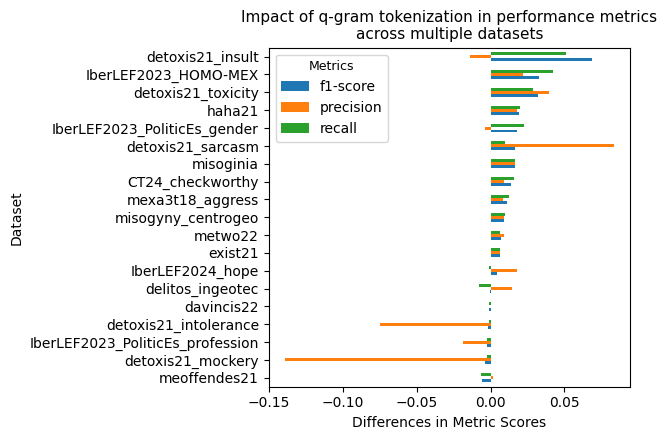

19


In [ ]:
import matplotlib.pyplot as plt

colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]  # F1, Precision, Recall

dff.plot(
    x="Dataset",
    y=["F1_d", "Precision_d", "Recall_d"],
    kind="barh",
    color=colors,
    figsize=(6.5, 4.5)
)

plt.xlabel("Differences in Metric Scores")
plt.ylabel("Dataset")
#plt.title("Impact of q-gram based tokenization on F1, Precision, and Recall\nacross multiple datasets")
plt.title("Impact of q-gram tokenization in performance metrics\nacross multiple datasets", fontsize=11)
plt.legend(["f1-score", "precision", "recall"], title='Metrics', title_fontsize='9')
plt.tight_layout()

#plt.savefig("/content/drive/MyDrive/Colab Notebooks/marzo_25/metrics_qgrams_6.png", dpi=300, bbox_inches="tight")

plt.show()

print(len(dff))

In [ ]:
df['Dataset'] = df['Dataset'].str.replace('grams/', '', regex=False)


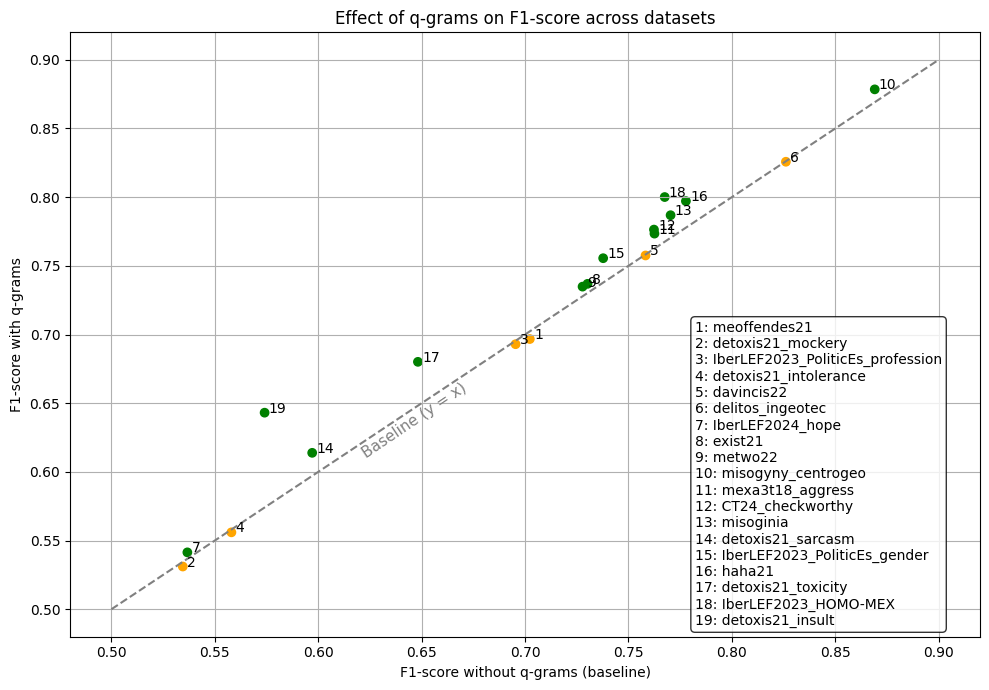

In [ ]:

colors = ['green' if delta >= 0 else 'orange' for delta in df['F1_d']]

df['Acronym'] = ['' + str(i+1) for i in range(len(df))]

plt.figure(figsize=(10, 7))
plt.scatter(df.F1, df.F1_q, color=colors)

for i, row in df.iterrows():
    plt.text(row['F1'] + 0.002, row['F1_q'], row['Acronym'])

plt.plot([0.5, 0.9], [0.5, 0.9], linestyle='--', color='gray', label='y = x')
plt.text(0.62, 0.61, 'Baseline (y = x)', color='gray', fontsize=11, rotation=34)

# Etiquetas y formato
plt.xlabel("F1-score without q-grams (baseline)")
plt.ylabel("F1-score with q-grams")
plt.title("Effect of q-grams on F1-score across datasets")
plt.grid(True)

labels = [f"{row['Acronym']}: {row['Dataset']}" for _, row in df.iterrows()]
legend_text = "Datasets:\n" + "\n".join(labels)
props = dict(boxstyle='round', facecolor='white', alpha=0.8)
plt.gcf().text(0.70, 0.10, legend_text, fontsize=10, bbox=props)

plt.tight_layout()
plt.show()